# Clasificación de perros y gatos con CNN

In [1]:
# Importar librerías
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### 1. Descargar conjunto de datos

El conjunto de datos que se estará utilizando es el de "Dogs vs Cats".

Se descargara el dataset del enlace y posteriormente se descomprimiran los archivos.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [3]:
# Location of downloaded dataset
zip_dir

'/Users/fernankiwi/.keras/datasets/cats_and_dogs_filterted.zip'

### 2. Exploración del conjunto de datos

In [4]:
# Obtener rutas de las carpetas para los datos de entrenamiento y prueba
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')  # Directorio con las imágenes de entrenamiento de gatos
train_dogs_dir = os.path.join(train_dir, 'dogs')  # Directorio con las imágenes de entrenamiento de perros
validation_cats_dir = os.path.join(validation_dir, 'cats')  # Directorio con las imágenes de prueba de gatos
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # Directorio con las imágenes de prueba de perros

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('Número de imágenes de entrenamiento de gatos:', num_cats_tr)
print('Número de imágenes de entrenamiento de perros:', num_dogs_tr)

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('Número de imágenes de prueba de gatos:', num_cats_val)
print('Número de imágenes de prueba de perros:', num_dogs_val)

Número de imágenes de entrenamiento de gatos: 1000
Número de imágenes de entrenamiento de perros: 1000
Número de imágenes de prueba de gatos: 500
Número de imágenes de prueba de perros: 500


### 3. Preparar los conjunto de datos

Generar mini batches de las imágenes con las transformaciones previamente realizadas

In [7]:
BATCH_SIZE = 64 # Tamaño del Batch
IMG_SHAPE  = 100 # Tamaño de la imagen

In [8]:
# Transformaciones con keras (Data Augmentation)
img_generator = ImageDataGenerator(rescale=1./255) # Reescalar imágenes  de 0-255 a 0-1

# ¿Qué otras transformaciones a priori se pueden utilizar?
#    - En este caso unicamente reescalamos entre 0 y 1.

In [ ]:
# img_generator = ImageDataGenerator(
#    rotation_range=40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest')

In [9]:
train = img_generator.flow_from_directory(
     batch_size=BATCH_SIZE, #Tamaño del Batch
     directory=train_dir, # Directorio del conjunto de datos de entrenamiento
     shuffle=True, # Aleatoriza las imágenes
     target_size=(IMG_SHAPE,IMG_SHAPE), # Cambiar el tamaño de las imágenes
     class_mode='binary') # Set “binary” if you have only two classes to predict

Found 2000 images belonging to 2 classes.


In [10]:
validation = img_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [11]:
img, label = train.next()
print('Tamaño del tensor:', img.shape)
print('Tamaño del tensor:', label.shape)

Tamaño del tensor: (64, 100, 100, 3)
Tamaño del tensor: (64,)


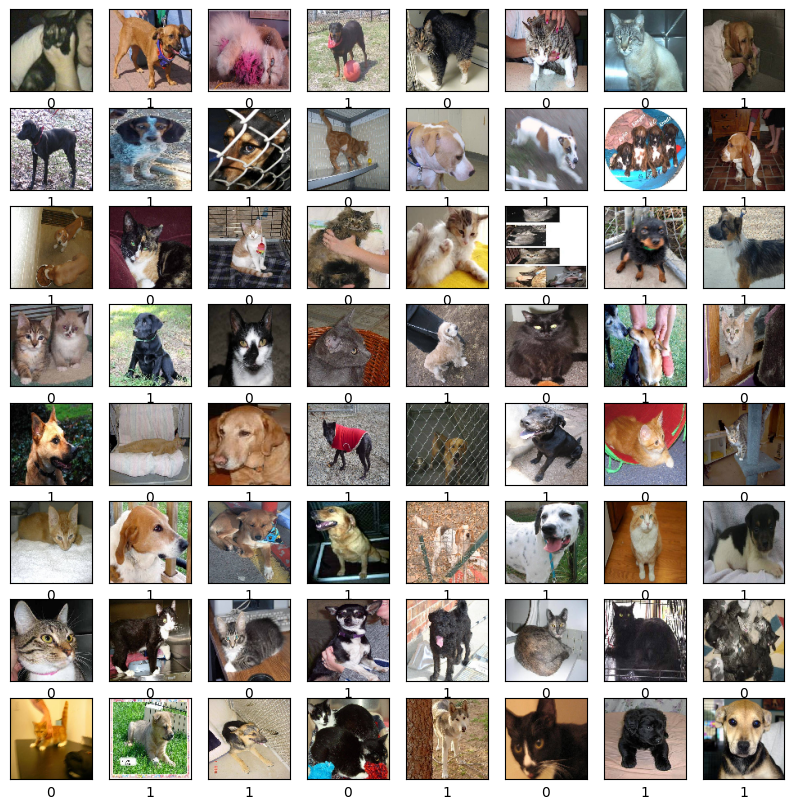

In [12]:
# Visualizar imágenes de entrenamiento
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    plt.xlabel(int(label[i]))
plt.show()

### 4. Definir la arquitectura del modelo

In [15]:
def build_model(img_shape):
  model = Sequential([
    Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(img_shape, img_shape, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
  ])

  return model

In [14]:
model = build_model(IMG_SHAPE)

In [16]:
# Definir optimizador, función de costo y métrica de clasificación
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Visualizar arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

### 5. Entrenar el modelo

In [18]:
# Early stopping para prevenir overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [19]:
# Definir número de épocas
EPOCHS = 18

In [20]:
history = model.fit(train, # Datos de entrenamiento
                    epochs=EPOCHS, # Número de épocas
                    validation_data=validation, # Datos de validación
                    callbacks=[early_stop])

Epoch 1/18
32/32 [==============================] - 5s 134ms/step - loss: 0.7046 - accuracy: 0.4975 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/18
32/32 [==============================] - 5s 159ms/step - loss: 0.6928 - accuracy: 0.5415 - val_loss: 0.6856 - val_accuracy: 0.5010
Epoch 3/18
32/32 [==============================] - 4s 115ms/step - loss: 0.6897 - accuracy: 0.5360 - val_loss: 0.6851 - val_accuracy: 0.5010
Epoch 4/18
32/32 [==============================] - 4s 114ms/step - loss: 0.6691 - accuracy: 0.5925 - val_loss: 0.6325 - val_accuracy: 0.6410
Epoch 5/18
32/32 [==============================] - 4s 113ms/step - loss: 0.6355 - accuracy: 0.6400 - val_loss: 0.6031 - val_accuracy: 0.6580
Epoch 6/18
32/32 [==============================] - 4s 118ms/step - loss: 0.5933 - accuracy: 0.6855 - val_loss: 0.6091 - val_accuracy: 0.6640
Epoch 7/18
32/32 [==============================] - 4s 124ms/step - loss: 0.5525 - accuracy: 0.7210 - val_loss: 0.5715 - val_accuracy: 0.7020
Epoch 

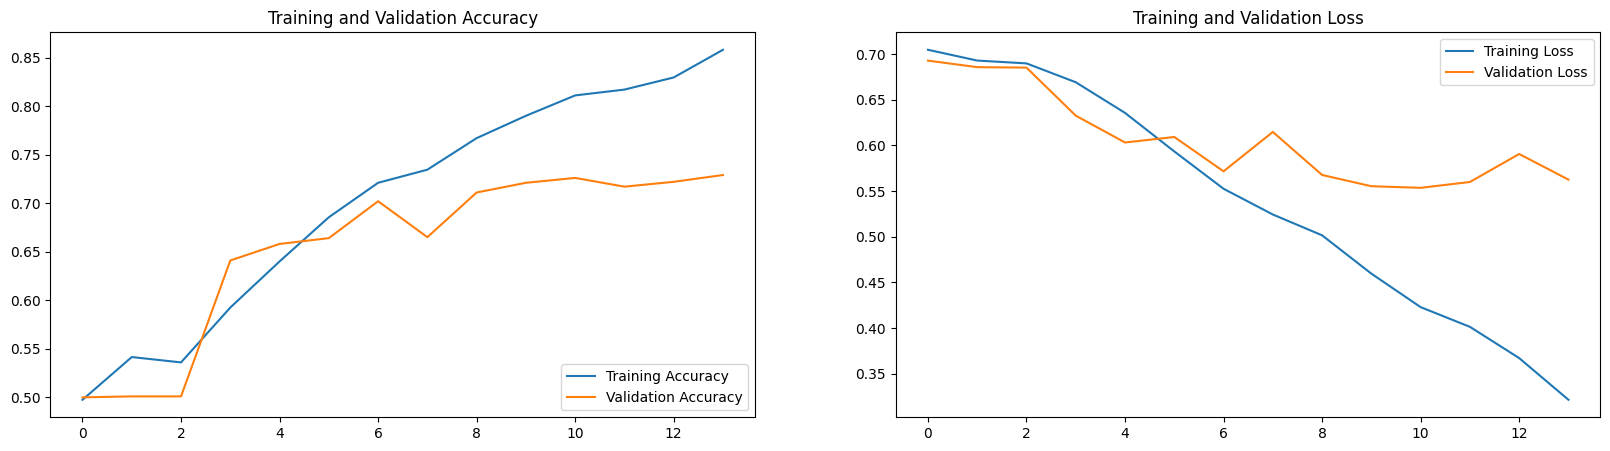

In [21]:
# Visualizar gráficas de aprendizaje
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(len(history.history['loss']))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

### 6. Realizar predicciones

In [22]:
img, label = validation.next()

In [23]:
y_pred = model.predict(img) # Predicción de imágenes con el modelo entrenado
y_pred_class = ((y_pred > 0.5)+0).ravel() # Asignar etiqueta a predicciones
y_pred_class

2/2 [==============================] - 0s 15ms/step


array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1])

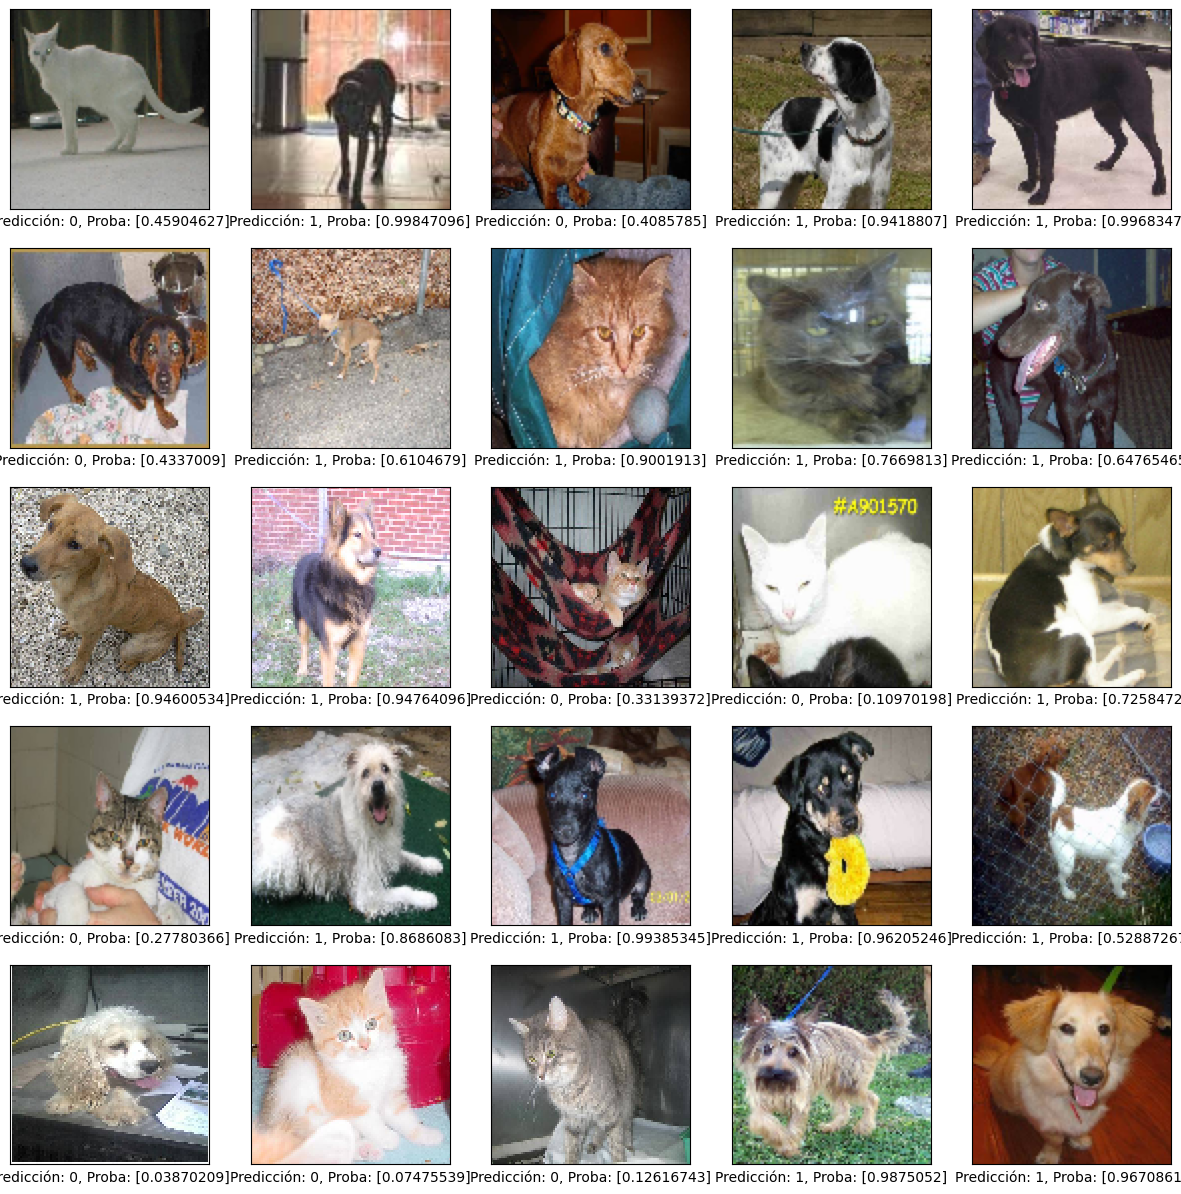

In [ ]:
# Visualización de resultados]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    plt.xlabel(f'Predicción: {y_pred_class[i]}, Proba: {y_pred[i]}')
plt.show()

# Aumento de Datos

In [25]:
from keras.preprocessing.image import load_img, img_to_array

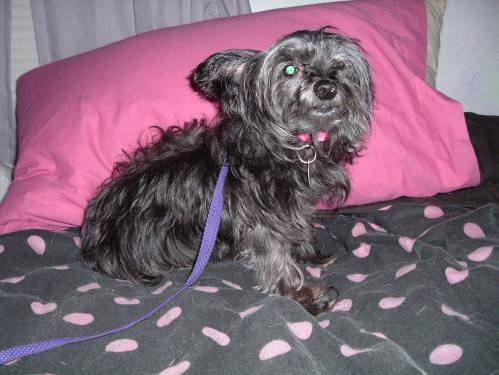

In [26]:
img = load_img('perrito.png')  # this is a PIL image
img

In [52]:
img_generator_validation =  ImageDataGenerator(rescale=1./255)

In [28]:
img_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [49]:
train = img_generator.flow_from_directory(batch_size=BATCH_SIZE, #Tamaño del Batch
                                               directory=train_dir, # Directorio del conjunto de datos de entrenamiento
                                               shuffle=True, # Aleatoriza las imágenes
                                               target_size=(IMG_SHAPE,IMG_SHAPE), # Cambiar el tama;o de las imágenes
                                               class_mode='binary') # Set “binary” if you have only two classes to predict

Found 2000 images belonging to 2 classes.


In [50]:
validation = img_generator_validation.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


In [33]:
x = img_to_array(img)  # this is a Numpy array with shape (375, 499, 3)
print(x.shape)
x =  np.expand_dims(x, axis=0)
print(x.shape)

(375, 499, 3)
(1, 375, 499, 3)


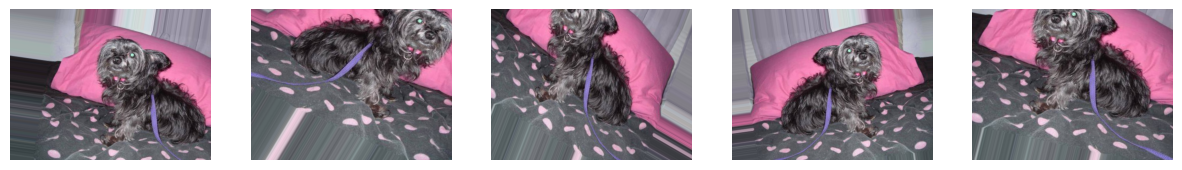

In [36]:
# Creates our batch of one image

pic = img_generator.flow(x, batch_size =1)
plt.figure(figsize=(15,15))
#Plots our figures
for i in range(1,6):
  plt.subplot(1, 5, i)
  batch = pic.next()
  image_ = batch[0]
  plt.imshow(image_)
  plt.axis('off')
plt.show()

In [37]:
img, label = train.next()
print('Tamaño del tensor:', img.shape)
print('Tamaño del tensor:', label.shape)

Tamaño del tensor: (64, 100, 100, 3)
Tamaño del tensor: (64,)


In [38]:
model2 = Sequential()

In [39]:
model2.add(Conv2D(32, (3, 3), activation='relu',input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [40]:
from tensorflow.keras import optimizers

In [41]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1./255) #todos los pixeles estarán entre 0 y 255
# test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
for data_batch, labels_batch in train:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

In [43]:
# Early stopping para prevenir overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [44]:
history = model.fit(train, # Datos de entrenamiento
                    epochs=EPOCHS, # Número de épocas
                    validation_data=validation, # Datos de validación
                    callbacks=[early_stop])

Epoch 1/18
32/32 [==============================] - 6s 181ms/step - loss: 0.6253 - accuracy: 0.6800 - val_loss: 0.5242 - val_accuracy: 0.7410
Epoch 2/18
32/32 [==============================] - 6s 171ms/step - loss: 0.6075 - accuracy: 0.6780 - val_loss: 0.5199 - val_accuracy: 0.7390
Epoch 3/18
32/32 [==============================] - 5s 161ms/step - loss: 0.6024 - accuracy: 0.6875 - val_loss: 0.5227 - val_accuracy: 0.7380
Epoch 4/18
32/32 [==============================] - 5s 159ms/step - loss: 0.5806 - accuracy: 0.7030 - val_loss: 0.5311 - val_accuracy: 0.7310
Epoch 5/18
32/32 [==============================] - 5s 156ms/step - loss: 0.5867 - accuracy: 0.6825 - val_loss: 0.5202 - val_accuracy: 0.7420
Epoch 6/18
32/32 [==============================] - 5s 159ms/step - loss: 0.5826 - accuracy: 0.6955 - val_loss: 0.5178 - val_accuracy: 0.7440
Epoch 7/18
32/32 [==============================] - 5s 157ms/step - loss: 0.5921 - accuracy: 0.6875 - val_loss: 0.5155 - val_accuracy: 0.7450
Epoch 

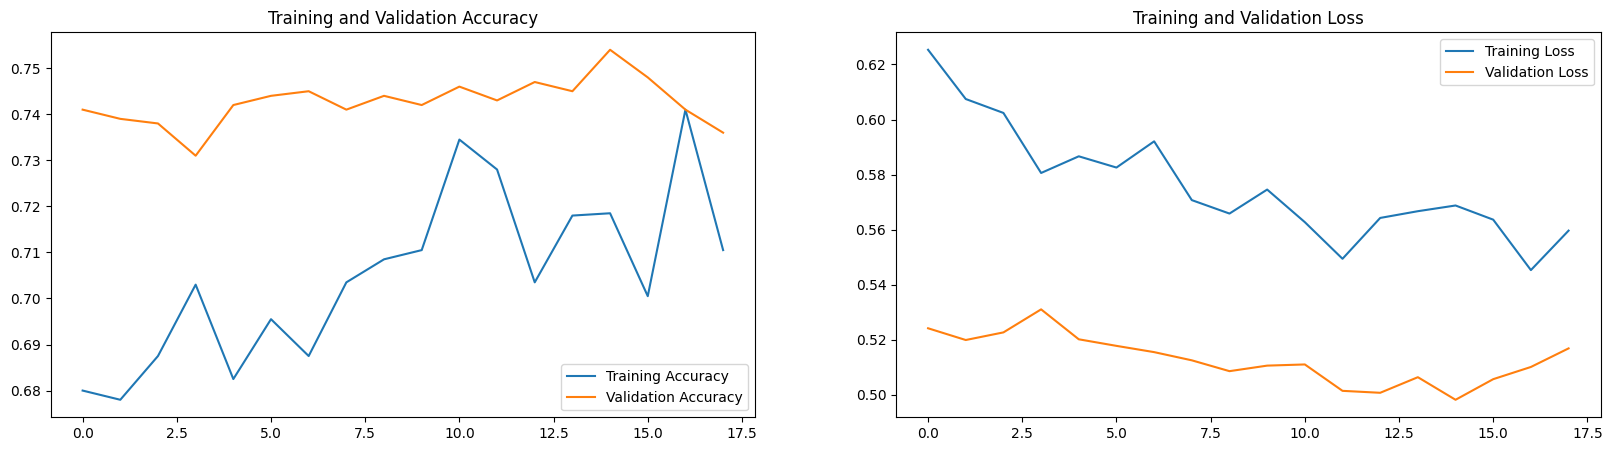

In [45]:
# Visualizar gráficas de aprendizaje
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(len(history.history['loss']))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

# Es mejor modelo o peor ?...

In [46]:
# Save model
model2.save('cats_and_dogs_small_02.h5')

/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
from tensorflow.keras.models import load_model

In [48]:
model = load_model('cats_and_dogs_small_02.h5')

# Ejercicio

Entrena con mas épocas y elige la mejor arquitectura + data augmentation.

Una vez que haya terminado de entrenarse el modelo, imprime las curvas de precision y de error.

Guarda el mejor modelo.

Carga el modelo seleccionado y realiza predicciones



# Pasos:

    1. Define la arquitectura del modelo
> model = Sequential()

    2. Compila el modelo
> model.compile(optimizer='', loss='', metrics=[''])

> 1. define un optimizador: e.g., adam = Adam(learning_rate=0.001)
> 2. define una función de costo: e.g., 'binary_crossentropy'
> 3. define las métricas de clasificación: e.g., metrics=['accuracy']

    3. Entrena el modelo
> model.fit(train=, epochs=, validation_data=, callbacks=)

> 1. train:

Defines un ImageDataGenerator() para **train**. Aqui haces transformaciones de las imágenes.

e.g., <br>
img_generator = ImageDataGenerator(

    rescale=1./255,
    
    rotation_range=40,
    
    width_shift_range=0.2,
    
    height_shift_range=0.2,
    
    shear_range=0.2,
    
    zoom_range=0.2,
    
    horizontal_flip=True,
    
    fill_mode='nearest'
)

<br>

> flow_from_directory()

Luego, ```flow_from_directory()``` configuras la lectura de las imágenes.
<br>

train = img_generator.flow_from_directory(
    
    batch_size=BATCH_SIZE, #Tamaño del Batch

    directory=train_dir, # Directorio del conjunto de datos de entrenamiento
    
    shuffle=True, # Aleatoriza las imágenes
    
    target_size=(IMG_SHAPE,IMG_SHAPE), # Cambiar el tamaño de las imágenes
    
    class_mode='binary' # Set “binary” if you have only two classes to predict

)

> 2. epochs

Defines el número de epocas

> 3. validation_data:

Defines otro ImageDataGenerator() para **validation_data**. Aqui solo escalas las imágenes.

e.g., <br>
img_generator_validation = ImageDataGenerator(
    
    rescale=1./255
)

> flow_from_directory()

Luego, ```flow_from_directory()``` configuras la lectura de las imágenes.
<br>

validation = img_generator_validation.flow_from_directory(
    
    batch_size=BATCH_SIZE,
    
    directory=validation_dir,
    
    target_size=(IMG_SHAPE, IMG_SHAPE),
    
    class_mode='binary'
    
)

> 4. callbacks

- agrega ```early stopping``` para prevenir overfitting: 

e.g., early_stop = EarlyStopping(monitor='val_loss', patience=3)

<div class="alert alert-block alert-info">

**1. Initialize model**
</div>

In [29]:
model3 = Sequential()

<div class="alert alert-block alert-info">

**2. Construct the architecture of the model**
</div>

In [20]:
BATCH_SIZE = 64 # Tamaño del Batch
IMG_SHAPE  = 100 # Tamaño de la imagen

In [30]:
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D

model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())
model3.add(Dropout(0.25))

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(1, activation='softmax'))

In [31]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 47, 47, 64)        256       
 chNormalization)                                                
                                                      

<div class="alert alert-block alert-info">

**3. Compile the model**
- New optimizer: **Adagrad** adapts the learning rates of each parameter, performing larger updates for infrequent parameters and smaller updates for frequent parameters.
</div>

In [32]:
model3.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

<div class="alert alert-block alert-info">

**4. Pipeline para data augmentation**
</div>

In [33]:
img_generator_validation_model3 =  ImageDataGenerator(rescale=1./255)

img_generator_model3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [34]:
train = img_generator_model3.flow_from_directory(
     batch_size=BATCH_SIZE,
     directory=train_dir,
     shuffle=True,
     target_size=(IMG_SHAPE,IMG_SHAPE),
     class_mode='binary'
)

validation = img_generator_validation_model3.flow_from_directory(
     batch_size=BATCH_SIZE,
     directory=validation_dir,
     target_size=(IMG_SHAPE, IMG_SHAPE),
     class_mode='binary'
)

Found 2000 images belonging to 2 classes.


Found 1000 images belonging to 2 classes.


<div class="alert alert-block alert-info">

**5. Early stopping para prevenir overfitting**
</div>

In [35]:
early_stop_model3 = EarlyStopping(monitor='val_loss', patience=10)

<div class="alert alert-block alert-info">

**6. EPOCHS**
</div>

In [36]:
EPOCHS_model3 = 20

<div class="alert alert-block alert-info">

**7. TRAIN THE MODEL**
</div>

In [37]:
model3_history = model3.fit(
     train,
     epochs=EPOCHS_model3,
     validation_data=validation,
     callbacks=[early_stop_model3]
)

Epoch 1/20
32/32 [==============================] - 18s 556ms/step - loss: 1.0426 - accuracy: 0.5000 - val_loss: 0.7031 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 25s 786ms/step - loss: 1.0722 - accuracy: 0.5000 - val_loss: 0.7380 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 25s 785ms/step - loss: 0.9522 - accuracy: 0.5000 - val_loss: 0.7839 - val_accuracy: 0.5000
Epoch 4/20
32/32 [==============================] - 24s 750ms/step - loss: 1.0185 - accuracy: 0.5000 - val_loss: 0.8414 - val_accuracy: 0.5000
Epoch 5/20
32/32 [==============================] - 23s 701ms/step - loss: 0.9919 - accuracy: 0.5000 - val_loss: 0.8980 - val_accuracy: 0.5000
Epoch 6/20
32/32 [==============================] - 23s 732ms/step - loss: 0.9478 - accuracy: 0.5000 - val_loss: 0.9606 - val_accuracy: 0.5000
Epoch 7/20
32/32 [==============================] - 22s 690ms/step - loss: 0.9952 - accuracy: 0.5000 - val_loss: 0.9957 - val_accuracy: 0.5000

<div class="alert alert-block alert-info">

**8. VISUALIZE TRAINING GRAPHS**
</div>

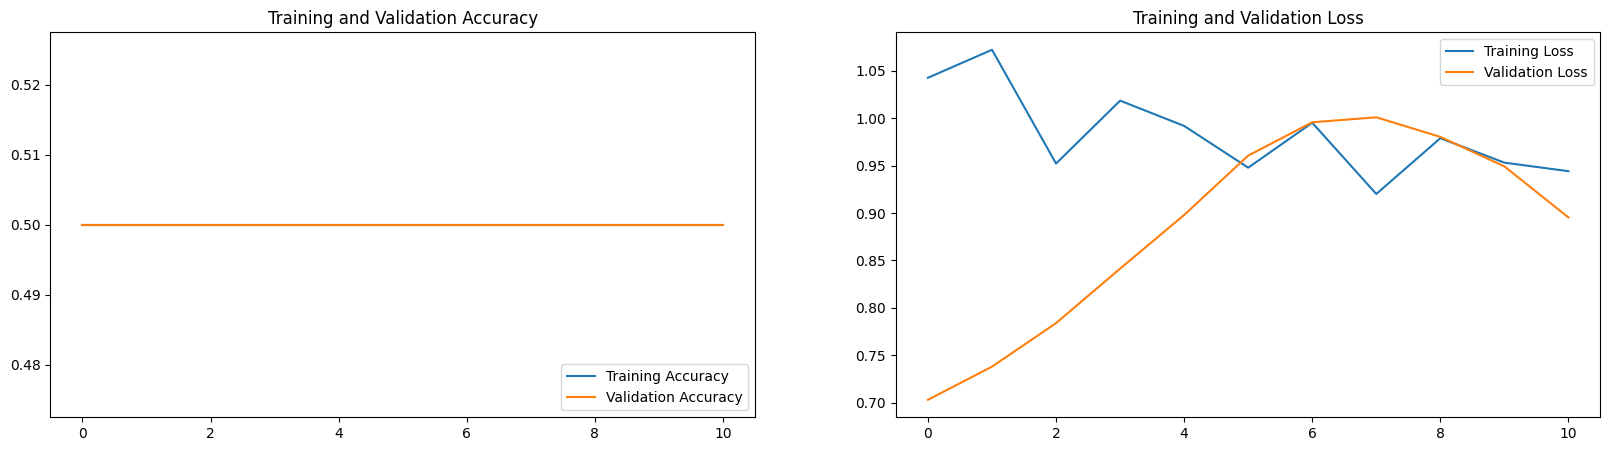

In [40]:
# Visualizar gráficas de aprendizaje
acc = model3_history.history['accuracy']
val_acc = model3_history.history['val_accuracy']

loss = model3_history.history['loss']
val_loss = model3_history.history['val_loss']

epochs_range = np.arange(len(model3_history.history['loss']))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./foo.png')
plt.show()

<div class="alert alert-block alert-info">

**9. SAVE THE MODEL**
</div>

In [16]:
model3.save('cats_and_dogs_MODEL_3.h5')

/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<div class="alert alert-block alert-info">

**10. LOAD THE MODEL**
</div>

In [ ]:
from tensorflow.keras.models import load_model

model3 = load_model('cats_and_dogs_MODEL_3.h5')

<div class="alert alert-block alert-info">

**11. MAKE PREDICTIONS**
</div>

In [ ]:
img = load_img('perrito_MODEL_3.png')  # this is a PIL image
img

y_pred = model.predict(img) # Predicción de imágenes con el modelo entrenado
y_pred_class = ((y_pred > 0.5)+0).ravel() # Asignar etiqueta a predicciones
y_pred_class